# Quantifying SAM's performance on segmentation of crops in satellite imagery 

 * File Created: Sunday, 14th May 2023 9:10:24 pm
 * Author: Rutuja Gurav (rgura001@ucr.edu)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

2.2.1
True
8


In [3]:
import sklearn
print(sklearn.__version__)

0.22.2.post1


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor']='white'
import seaborn as sns
sns.set(rc={'axes.facecolor':'white', 
            'figure.facecolor':'white',
        })

from scipy import ndimage
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
import sys, glob, os, collections
from pprint import pprint

## Download SAM weights

Find explanation of SAM's parameters here - 
(SAM paper) https://arxiv.org/abs/2304.02643
(Blog) https://replicate.com/pablodawson/segment-anything-automatic

In [4]:
# !wget --directory-prefix=cached_models https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
# !wget --directory-prefix=cached_models https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
# !wget --directory-prefix=cached_models https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2023-06-20 16:57:20--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.225.142.88, 13.225.142.76, 13.225.142.121, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.225.142.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘cached_models/sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  94.2MB/s    in 23s     

2023-06-20 16:57:43 (106 MB/s) - ‘cached_models/sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]

--2023-06-20 16:57:44--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.225.142.88, 13.225.142.76, 13.225.142.121, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.225.142.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1249524607 (1.2G) [

## Example: Segmenting CalCrop21 Images

CalCrop21[1] is a benchmark dataset that contained 4D spatiotemporal multispectral tiles of satellite imagery from Sentinel-2 satellite for the year 2018 for Central Valley, CA agricultural fields along with the corresponding ground-truth crop-map (CDL) for each tile. As SAM is limited to 3-channel RGB inputs, we have to use RGB channels from an appropriate timestep in the year. We have decided this appropriate timestep to be the maximum NDVI timestep.  

[1] Ghosh, Rahul, et al. "Calcrop21: A georeferenced multi-spectral dataset of satellite imagery and crop labels." 2021 IEEE International Conference on Big Data (Big Data). IEEE, 2021.

### [TESTING] Creating RGB composite and cropping them at different AOI sizes with sliding window.

Note: This is implemented in make_aoi_samples.py. Run that script in background for the full dataset, do not run this in notebook!

In [5]:
import glob
DATA_DIR = "/data/hpate061/CalCROP21/ACCEPTABLE_GRIDS"
if not os.path.exists(DATA_DIR): print("Remember to change DATA_DIR to your local path where you downloaded the CalCrop21 dataset.")

filepaths = glob.glob(DATA_DIR+"/IMAGE_GRIDS/*.npy")
print(len(filepaths))
print(filepaths[:2])
tile_ids = [fp.split('/')[-1].rsplit('_',1)[0] for fp in filepaths]
print(tile_ids[:2])

367
['/data/hpate061/CalCROP21/ACCEPTABLE_GRIDS/IMAGE_GRIDS/T10SFH_2018_2_1_IMAGE.npy', '/data/hpate061/CalCROP21/ACCEPTABLE_GRIDS/IMAGE_GRIDS/T11SKV_2018_4_9_IMAGE.npy']
['T10SFH_2018_2_1', 'T11SKV_2018_4_9']


Compute NDVI cube for a tile, then use max NDVI timestep to create RGB render.

NDVI = (B8-B4) / (B8+B4)

In [6]:
with open("unusable_tiles.txt", 'r') as file:
    unusable_tiles = [line.rstrip() for line in file]
    
print(len(unusable_tiles))

20


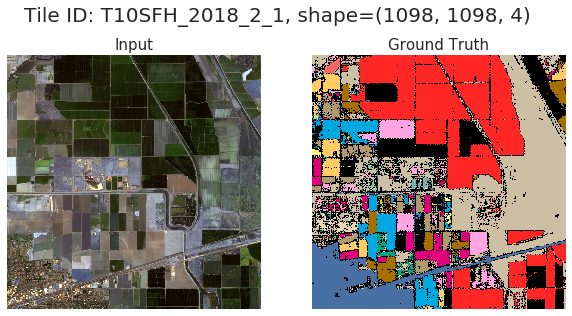

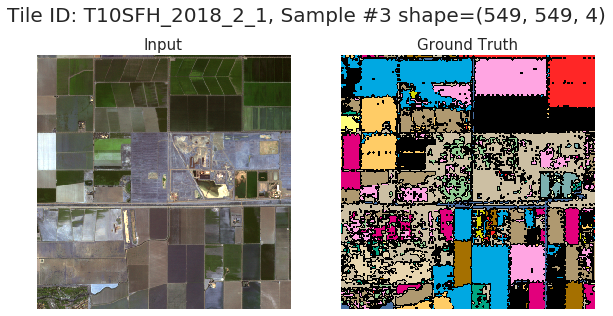

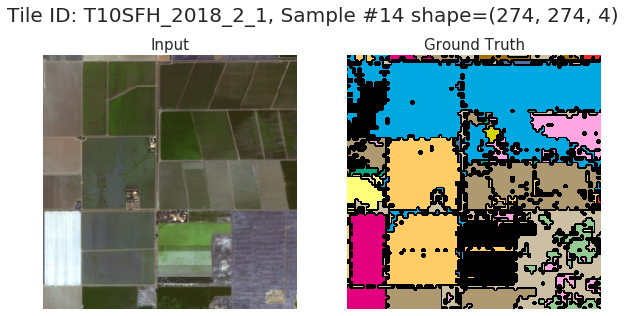

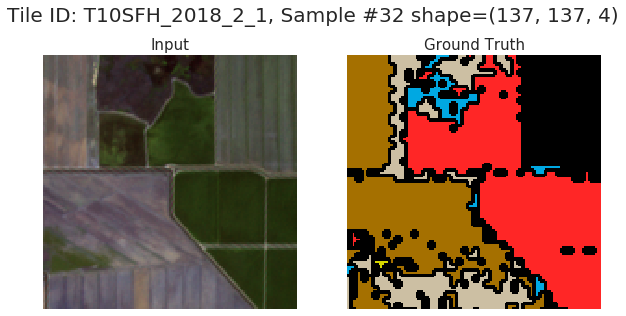

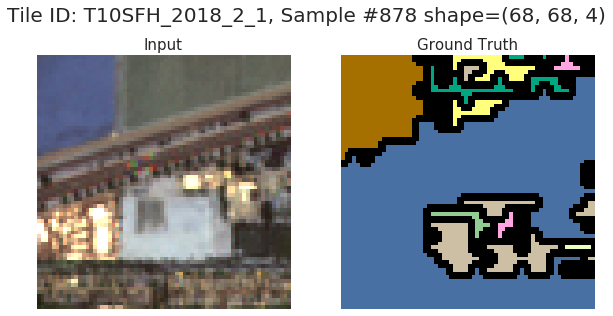

In [21]:
import skimage
from utils import plot_sample

## Set the overlap ratio for the sliding window
overlap = 0.5

## Ususable tiles are either all black in RGB or are too contaminated with clouds and errors introduced while removing them...
## Only process 1 tiles for demonstration purposes.
usable_tile_ids = [_id for _id in tile_ids if _id not in unusable_tiles]
id_ = usable_tile_ids[0] ## Pick the first usable tile for demonstration purposes.

## Load the image and the ground truth mask
image_multispec = np.load(DATA_DIR+"/IMAGE_GRIDS/{}_IMAGE.npy".format(id_))
gt_mask = np.load(DATA_DIR+"/PREPROCESSED_CDL_GRIDS/{}_PREPROCESSED_CDL_LABEL.npy".format(id_))
# print(image_multispec.shape, gt_mask.shape)

B4, B8 = image_multispec[:,2,:,:], image_multispec[:,6,:,:]
image_ndvi = np.divide((B8-B4), (B8+B4), out=np.zeros_like(B8), where=B4!=0)
# print(image_ndvi.shape)
max_ndvi_timestep = np.argmax(np.mean(image_ndvi, axis=(1,2)))
# sorted_ndvi_timesteps = np.mean(image_ndvi, axis=(1,2)).argsort()[-24:][::-1]
# print(max_ndvi_timestep)
image = image_multispec[max_ndvi_timestep,[0,1,2],:,:].T * 255
image = image.astype(int)
# print(image.shape, image.min(), image.max())
image = ndimage.rotate(np.fliplr(image), angle=90).astype('uint8')

datapoint = np.concatenate((image, gt_mask[..., np.newaxis]), axis=-1) 

##-----------DEBUG----------------------
plot_sample(img=datapoint[...,:3], mask=datapoint[...,-1], 
            titlestr=f"Tile ID: {id_}, shape={datapoint.shape}", 
            show=True)
##--------------------------------------

max_shape = datapoint.shape[0]
for split_ratio in [2, 4, 8, 16]:
    window_size = (max_shape//split_ratio, max_shape//split_ratio, datapoint.shape[-1])
    # views = np.lib.stride_tricks.sliding_window_view(datapoint, window_size, axis=(0,1))
    views = skimage.util.view_as_windows(datapoint, window_size, step=int(overlap*window_size[0])).squeeze()
    # print(views.shape)
    
    samples = views.reshape(-1, views.shape[2], views.shape[3], views.shape[4])
    # print(samples.shape)
    
    ## Grab a random patch from the list of samples
    sample_idx = np.random.randint(0, samples.shape[0])
    sample = samples[sample_idx, ...]
    
    ##-----------DEBUG----------------------
    plot_sample(img=sample[...,:3], mask=sample[...,-1], 
                titlestr=f"Tile ID: {id_}, Sample #{sample_idx} shape={sample.shape}", 
                show=True)
    ##--------------------------------------

### Visualize sample

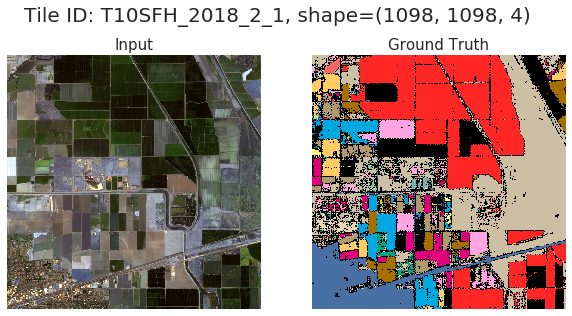

In [27]:
image, gt_mask = datapoint[...,:3], datapoint[...,-1]
aoi_size = image.shape[0]
plot_sample(img=image, mask=gt_mask, 
            titlestr=f"Tile ID: {id_}, shape={datapoint.shape}", show=True)

### [TESTING] Predict mask and visualize

Using limited no. of hyperparmeters for demostration purposes. Larger set of hyperparameters used in `grid_search.py`.

In [26]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

MODEL_DIR = "../cached_models"
model_type = "vit_h"
sam_checkpoint = [fp for fp in glob.glob(MODEL_DIR+'/*.pth') if model_type in fp][0]
print(sam_checkpoint)
device = "cuda:7"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device=device)

../cached_models/sam_vit_h_4b8939.pth


Full explanation of all options available in `SamAutomaticMaskGenerator` can be found here - https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/automatic_mask_generator.py

  0%|          | 0/1 [00:00<?, ?it/s]

Defining mask generator...
DONE!
Generating masks...
For sample T10SFH_2018_2_1, SAM generated 403 boolean masks!
Max cluster id = 255
num_labels_in_pred_mask = 241
DONE!
Evaluating clustering consensus...


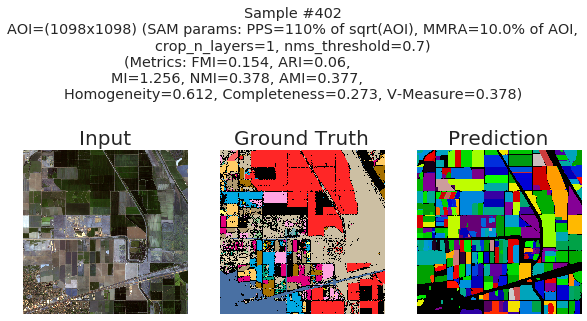

In [30]:
from utils import plot_prediction, eval_clustering

img_w, img_h = aoi_size, aoi_size
min_mask_region_fracs_vals = [1e-1]
pps_frac_vals = [0.1]
crop_n_layers_vals = [1]
crop_n_points_downscale_factor = 1
nms_thresh = 0.7

for pps_frac in pps_frac_vals:
    pps = np.ceil(pps_frac*img_w).astype(int)
    pps_perc = pps_frac*100
    for min_mask_area_frac in tqdm(min_mask_region_fracs_vals, leave=False):
        min_mask_area = int(min_mask_area_frac*img_w*img_h)
        min_mask_area_perc = min_mask_area_frac*100
        for crop_n_layers in crop_n_layers_vals:
            print("Defining mask generator...")
            mask_generator = SamAutomaticMaskGenerator(model=sam,
                                                        points_per_side=pps,
                                                        pred_iou_thresh=0.95,
                                                        stability_score_thresh=0.95,
                                                        box_nms_thresh=nms_thresh,
                                                        crop_nms_thresh=nms_thresh,
                                                        crop_n_layers=crop_n_layers,
                                                        crop_n_points_downscale_factor=crop_n_points_downscale_factor,
                                                        min_mask_region_area=min_mask_area,  # Requires open-cv to run post-processing
                                                    )
            print("DONE!")

            print("Generating masks...")
            masks = mask_generator.generate(image)
            # print(masks[0].keys())
            print("For sample {}, SAM generated {} boolean masks!".format(id_, len(masks)))
            ## Sort masks by stability score
            masks = sorted(masks, key=lambda d: d['stability_score']) 

            ## How many pixels got no mask?
            # pred_mask = np.logical_or.reduce(np.array([mask['segmentation'] for mask in masks]), axis=0)
            # print(pred_mask.shape)
            # print(collections.Counter(pred_mask.flatten()))

            ## Checking for any overlap in the masks
            # bin_masks = np.array([np.array(mask['segmentation']).astype(int) for mask in masks])
            # print(collections.Counter(bin_masks.flatten()))
            # pred_mask = np.sum(bin_masks, axis=0)
            # print(pred_mask.shape)
            # print(collections.Counter(pred_mask.flatten()))

            ## Transform N boolean overlapping masks into one numerically encoded mask
            pred_mask = np.zeros((image.shape[0], image.shape[1]))
            # pred_mask = masks[0]['segmentation'].astype(int)
            for i in range(len(masks)):
                val = i+1
                pred_mask += masks[i]['segmentation'].astype(int) * val
                pred_mask = np.where(pred_mask > val, val, pred_mask)
            pred_mask = pred_mask.astype('uint8')
            print(f"Max cluster id = {pred_mask.flatten().max()}")
            print(f"num_labels_in_pred_mask = {len(np.unique(pred_mask))}")
            print("DONE!")

            print("Evaluating clustering consensus...")
            clust_score = eval_clustering(gt_mask.flatten(), pred_mask.flatten())
            clust_score['num_labels_in_pred_mask'] = len(np.unique(pred_mask))
            clust_score['num_labels_in_gt_mask'] = len(np.unique(gt_mask))

            titlestr = "AOI=({}x{}) (SAM params: PPS={}% of sqrt(AOI), MMRA={}% of AOI,\ncrop_n_layers={}, nms_threshold={})".\
                                    format(img_w, img_h, pps, min_mask_area_perc, crop_n_layers, nms_thresh)
                        
            titlestr += f"\n(Metrics: FMI={clust_score['FMI']}, ARI={clust_score['ARI']},\
                        \nMI={clust_score['MI']}, NMI={clust_score['NMI']}, AMI={clust_score['AMI']},\
                        \nHomogeneity={clust_score['Homogeneity']}, Completeness={clust_score['Completeness']}, V-Measure={clust_score['V-Measure']})"
            titlestr = f"Sample #{i}\n"+titlestr
            plot_prediction(input=image, gt_mask=gt_mask, pred_mask=pred_mask, 
                            titlestr=titlestr,
                            show=True
                        )